# Predict parent neuron
Using Jasper's idea to predict parent neurons for nuclei, Thank you so much, Jasper.

In [1]:
# libraries 1
import numpy as np
import pyperclip
import pandas as pd
import pyperclip
from cloudvolume import CloudVolume, view, Bbox
from nglui import statebuilder,annotation,easyviewer,parser
from nglui.statebuilder import *
import json
from tqdm import tqdm
import argparse

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os
import csv

from tifffile.tifffile import imwrite

sys.path.append(os.path.abspath("../segmentation"))
import authentication_utils as auth
import rootID_lookup as IDlook
sys.path.append(os.path.abspath("../synapses"))
import connectivity_utils

%matplotlib inline

In [2]:
np.random.seed(123)
# read csv file
df = pd.read_csv('../Output/body_info_Aug2021.csv', header=0)
len(df)

17076

# A. Create Neuroglancer links for Nucleus Proofreading
based on https://github.com/bjm5164/rotation_projects/blob/main/statebuilder_examples.ipynb

In [ ]:
# color_column not supported for point annotation
imgTokyo = ImageLayerConfig(name = 'FANC_EM_Tokyo',
                                    source = auth.get_cv_path('Image_Tokyo')['url'])
img = ImageLayerConfig(name = 'FANC_EM',
                                    source = auth.get_cv_path('Image')['url'])
nuc_Aug = ImageLayerConfig(name = 'nuclei_Aug2021',
                                    source = auth.get_cv_path('nuclei_map_Aug2021')['url'])      
nuc_seg_Aug = ImageLayerConfig(name = 'nuclei_Aug2021_seg',
                                    source = auth.get_cv_path('nuclei_seg_Aug2021')['url'])      
nuc_Jul = ImageLayerConfig(name = 'nuclei_Jul2021',
                                    source = auth.get_cv_path('nuclei_map_Jul2021')['url'])      
nuc_seg_Jul = ImageLayerConfig(name = 'nuclei_Jul2021_seg',
                                    source = auth.get_cv_path('nuclei_seg_Jul2021')['url'])   
seg = SegmentationLayerConfig(name = 'FANC_production_segmentation',
                                    # selected_ids_column='nuc_segID',
                                    source = auth.get_cv_path('FANC_production_segmentation')['url'])      


df2 = df.assign(pt_position=[*zip(df.x, df.y, df.z)])
points = PointMapper(point_column='pt_position')
ann = AnnotationLayerConfig(name='nuc_center_Aug', mapping_rules=points, color='#32CB42',active = True,)      
sb = StateBuilder(layers=[imgTokyo, seg, img, nuc_Aug, nuc_seg_Aug, nuc_Jul, nuc_seg_Jul, ann],resolution=[4.3,4.3,45]) # view_kws=view_options

client,token = auth.get_client()

state = json.loads(sb.render_state(df2, return_as='json'))

out =auth.get_cv_path('neuroglancer_base')['url'] + '?json_url={path}{state_id}'.format(path=auth.get_cv_path('json_server')['url'],state_id=client.state.upload_state_json(state))
out
# https://neuromancer-seung-import.appspot.com/?json_url=https://api.zetta.ai/json/692331708447824330
# https://github.com/htem/FANC_auto_recon/blob/main/proofreading/proofreading_utils.py



LINK=[]
k=200
minidfs = [df.loc[i:i+k-1, :] for i in range(0, len(df), k)]
for dftemp in minidfs:
    seg = SegmentationLayerConfig(name = 'FANC_production_segmentation',
                                        # selected_ids_column='nuc_segID',
                                        source = auth.get_cv_path('FANC_production_segmentation')['url'])                                 
    sb = StateBuilder(layers=[imgTokyo, seg, img, nuc, nuc_seg],resolution=[4.3,4.3,45]) # view_kws=view_options
    output = sb.render_state(dftemp) #return_as='html'
    LINK.append(output)

In [ ]:
# https://api.zetta.ai/json/post

In [ ]:
# save into csv
LINK2 = pd.DataFrame(LINK)
LINK2.to_csv('../Output/nuc_links.csv', index=False, header=False)

# B. Test my soma list with other table

In [ ]:
# T1MN_somas test
MNsomas = pd.read_csv('../Output/T1MN_somas.csv', header=0)
MNsomas['pt_root_id'].values

exist = []
no_exist = []
for i in MNsomas['pt_root_id'].values:
    if i in df['body_segID'].values:
        exist.append(i)
    else:
        no_exist.append(i)

print(no_exist)

In [ ]:
check = 648518346486520985
print (MNsomas.loc[MNsomas['pt_root_id'] == check])

In [ ]:
nuc = 648518346481315476
df[df['nuc_segID']==nuc]

# C. Summarize count data

In [ ]:
count = pd.read_csv('../Output/ncount_merged.csv', header=None)
count2 = count.T.dropna()
# len(count2) 
# 15094
count3 = count2.sort_values(by=0)
count4 = count3.astype('int')
count4.columns = ['index', 'count']

In [ ]:
sv_size_thres=4000
chosen = count4.loc[count4['count'] <= sv_size_thres]
chosen['index'].values

In [ ]:
test = df.loc[chosen['index'].values]
test[0:999]
rantest = test.iloc[np.random.choice(len(test), round(len(test)/5), replace=False)]

In [ ]:
# nuclei itself
imgTokyo = ImageLayerConfig(name = 'FANC_EM_Tokyo',
                                    source = auth.get_cv_path('Image_Tokyo')['url'])
img = ImageLayerConfig(name = 'FANC_EM',
                                    source = auth.get_cv_path('Image')['url'])
nuc = ImageLayerConfig(name = 'nuclei(old)',
                                    source = auth.get_cv_path('nuclei_map')['url'])                                    
# volume = SegmentationLayerConfig(name = 'volume_outlines',
#                                    source = auth.get_cv_path('Image')['url'])   

seg = SegmentationLayerConfig(name = 'FANC_production_segmentation',
                                        active = True,
                                        source = auth.get_cv_path('FANC_production_segmentation')['url'],
                                        selected_ids_column='segIDs')                                 
sb = StateBuilder(layers=[imgTokyo, seg, nuc, img],resolution=[4.3,4.3,45]) # view_kws=view_options
output = sb.render_state(rantest, return_as='html')
output

In [ ]:
sv_size_thres=4000
notchosen = count4.loc[count4['count'] > sv_size_thres+2000]
test2 = df.loc[notchosen['index'].values]
test2

In [ ]:
rantest2 = test2.iloc[np.random.choice(len(test2), round(len(test2)/5), replace=False)]
output = sb.render_state(rantest2, return_as='html')
output

# D. Get premotor inputs

In [ ]:
# get premotor inputs
MN = pd.read_csv('../Output/MNs.csv', header=0)
MN

# E. point map

In [ ]:
# color_column not supported for point annotation
imgTokyo = ImageLayerConfig(name = 'FANC_EM_Tokyo',
                                    source = auth.get_cv_path('Image_Tokyo')['url'])
img = ImageLayerConfig(name = 'FANC_EM',
                                    source = auth.get_cv_path('Image')['url'])
nuc_Aug = ImageLayerConfig(name = 'nuclei_Aug2021',
                                    source = auth.get_cv_path('nuclei_map_Aug2021')['url'])      
nuc_seg_Aug = ImageLayerConfig(name = 'nuclei_Aug2021_seg',
                                    source = auth.get_cv_path('nuclei_seg_Aug2021')['url'])      
nuc_Jul = ImageLayerConfig(name = 'nuclei_Jul2021',
                                    source = auth.get_cv_path('nuclei_map_Jul2021')['url'])      
nuc_seg_Jul = ImageLayerConfig(name = 'nuclei_Jul2021_seg',
                                    source = auth.get_cv_path('nuclei_seg_Jul2021')['url'])   
# volume = SegmentationLayerConfig(name = 'volume_outlines',
#                                    source = auth.get_cv_path('Image')['url'])   

seg = SegmentationLayerConfig(name = 'FANC_production_segmentation',
                                    active = True,
                                    source = auth.get_cv_path('FANC_production_segmentation')['url'])

df2 = df.assign(pt_position=[*zip(df.x, df.y, df.z)])
points = PointMapper(point_column='pt_position')
ann = AnnotationLayerConfig(name='nuc_center_Aug', mapping_rules=points, color='#32CB42')      
sb = StateBuilder(layers=[imgTokyo, seg, img, nuc_Aug, nuc_seg_Aug, nuc_Jul, nuc_seg_Jul, ann],resolution=[4.3,4.3,45]) # view_kws=view_options

client,token = auth.get_client()

state = json.loads(sb.render_state(df2, return_as='json'))

out =auth.get_cv_path('neuroglancer_base')['url'] + '?json_url={path}{state_id}'.format(path=auth.get_cv_path('json_server')['url'],state_id=client.state.upload_state_json(state))
out
# https://neuromancer-seung-import.appspot.com/?json_url=https://api.zetta.ai/json/692331708447824330
# https://github.com/htem/FANC_auto_recon/blob/main/proofreading/proofreading_utils.py

In [ ]:
# https://api.zetta.ai/json/post

# F. Descending and Ascending neurons

In [23]:
# read data
left_d = np.fromfile('../Output/da/left_d.bin', dtype=np.int64)
left_a = np.fromfile('../Output/da/left_a.bin', dtype=np.int64)
right_d = np.fromfile('../Output/da/right_d.bin', dtype=np.int64)
right_a = np.fromfile('../Output/da/right_a.bin', dtype=np.int64)

pMN_T1L = pd.read_csv('../Output/da/pMN_T1L.csv', header=0)
pMN_T1R = pd.read_csv('../Output/da/pMN_T1R.csv', header=0)

In [24]:
df_temp = pd.concat([pMN_T1L, pMN_T1R], axis=0)
aggregation_functions = {'synapses': 'sum'}
pMN_T1all = df_temp.groupby(df_temp['root_id']).aggregate(aggregation_functions)

In [28]:
def find_T1input(array, threshold=3):
    left = array[np.isin(array, pMN_T1L[pMN_T1L['synapses'] >= threshold]['root_id'].values)]
    right = array[np.isin(array, pMN_T1R[pMN_T1R['synapses'] >= threshold]['root_id'].values)]
    both = np.intersect1d(left, right)
    others = array[np.isin(array,np.unique(np.concatenate((left, right))), invert=True)]

    return np.array([len(both), len(left), len(right), len(others)])/len(array), np.array([len(both), len(left), len(right), len(others)])

In [29]:
# Left descending
Ld, Ld_abs = find_T1input(left_d, threshold=10)
La, La_abs = find_T1input(left_a, threshold=10)
Rd, Rd_abs = find_T1input(right_d, threshold=10)
Ra, Ra_abs = find_T1input(right_a, threshold=10)

In [30]:
np.vstack([Ld_abs, La_abs, Rd_abs, Ra_abs])

array([[   7,   15,   56,  782],
       [   7,    9,  118,  930],
       [   7,   47,   11,  465],
       [   5,  101,    6, 1228]])

<AxesSubplot:>

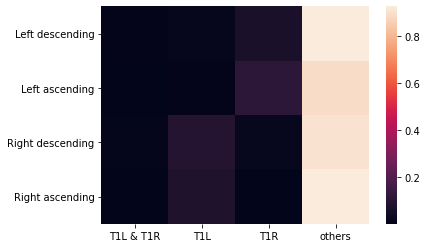

In [27]:
g = pd.DataFrame(data=np.vstack([Ld, La, Rd, Ra]),
                                index=['Left descending', 'Left ascending', 'Right descending', 'Right ascending'],
                                columns=['T1L & T1R', 'T1L', 'T1R', 'others'])
plt.figure()
sns.heatmap(g)

In [ ]:
MNinputs = pd.read_csv('../Output/da/MNinputs.csv', header=0, index_col=0)
DANoutputs = pd.read_csv('../Output/da/DANoutputs.csv', header=0, index_col=0)

In [ ]:
t(DANoutputs)
# sum row column add